## 4° Teste

Neste teste pretendo utilizar o fato de conseguir segmentar o tronco encefálico de forma mais consistente que o CC para então usar ele como um ponto de referência. A partir da posição do TE determina-se uma região que contém o CC, com isso basta aplicar um filtro de média para encontrar um pixel em seu interior.

In [1]:
# Importando pacotes

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage.filters as skf
from skimage.segmentation import watershed
from skimage.morphology import remove_small_holes, remove_small_objects
import nibabel as nib
import pandas as pd

In [2]:
# Definindo funções e variáveis para carregar imagens

dir_name = "../data/raw/"
img_data = pd.read_csv("../data/description.csv", dtype=str)

def getFilenameFromID(df, Id):
    file_name = "CC"
    for h in df.columns:
        file_name+=df[h][Id]+'_'
    file_name= file_name[:-1]+".nii"
    return file_name

def loadRandomImage():
    random_id = np.random.randint(0,high=358)
    file_name = getFilenameFromID(img_data, random_id)
    f = nib.load(dir_name+file_name).get_fdata()

    x = int(f.shape[0]/2)
    img = ndi.rotate(f[x,:,:], 90)

    img = 255*img/np.max(img)
    img = img.astype(np.uint8)
    return img, file_name

In [41]:
# Definindo o processo de watershed que passamos a usar no teste 3

def watershedFromPoint(img, target_x, target_y, threshold_width, plot=False):
    n_mean = 5
    mean_filter = 1/(n_mean**2)*np.ones((n_mean, n_mean))
    mean_img = skf.edges.convolve(img, mean_filter)
    
    target_value = mean_img[target_y, target_x]
    
    threshold_img = np.ones(img.shape, np.int8)
    lower_limit, upper_limit = max(target_value-threshold_width, 0), min(target_value+threshold_width, 255)
    threshold_img[img < lower_limit] = 0
    threshold_img[img > upper_limit] = 0

    distance = ndi.distance_transform_edt(threshold_img)

    markers = np.zeros(distance.shape, dtype=bool) 
    markers = (distance==0)*1
    markers[target_y, target_x] = 2

    labels = watershed(-distance, markers)

    # Removendo objetos pequenos e buracos
    f0 = remove_small_holes(labels-1, 64)
    final = remove_small_objects(f0, min_size=300)

    # Plot
    if plot:
        fig, axes = plt.subplots(ncols=5, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title('Original')
        ax[1].imshow(threshold_img, cmap=plt.cm.gray)
        ax[1].set_title('Threshold')
        ax[2].imshow(distance, cmap=plt.cm.gray)
        ax[2].set_title('Distance')
        ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
        ax[3].set_title('Watershed')
        ax[4].imshow(final, cmap=plt.cm.gray)
        ax[4].set_title('Final')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    return final

In [8]:
def getBrainstemPosition(f):
    height, width = f.shape
    x_min, x_max = width//2-40, width//2+20
    y_min, y_max = height//3, 9*height//10
    brainstem = f[y_min:y_max, x_min:x_max]
    
    sub_height, sub_width = brainstem.shape
    
    h_x, h_y = 11, sub_height//2
    h_filter = (1/(h_y*h_x))*(np.ones((h_y,h_x)))
    
    mean_img = skf.edges.convolve(brainstem, h_filter, mode="wrap")
    
    mean_img_id_max = np.argmax(mean_img)
    
    brainstem_y = mean_img_id_max//sub_width + y_min
    brainstem_x = mean_img_id_max%sub_width + x_min
    
    return brainstem_x, brainstem_y

In [9]:
def getCCPositionFromSubImg(f, x_min, y_min):
    height, width = f.shape    
    n_mean=11
    mean_img = skf.median(f, np.ones((n_mean,n_mean))/n_mean**2)
    mean_img_id_max = np.argmax(mean_img)
    
    cc_y = mean_img_id_max//width
    cc_x = mean_img_id_max%width
    
    return cc_x+x_min, cc_y+y_min

In [34]:
def getSubImgFromBrainstem(img, brainstem):
    height, width = img.shape
    center_y = height//2
    center_x = width//2 
    brainstem_size = np.sum(brainstem)
    if 25<brainstem_size<2000:
        reference_y = 0
        for i in range(height):
            if np.sum(brainstem[i,:]) > 0:
                reference_y = i
                break
   
        min_y, max_y = reference_y-50, reference_y-10
        min_x, max_x = center_x-50, center_x+50
    else:
        min_y, max_y = 75, center_y
        min_x, max_x = center_x-50, center_x+50
        
    return img[min_y:max_y, min_x:max_x], min_x, min_y

CC0356_ge_3_61_F.nii


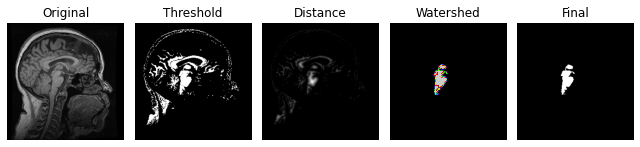

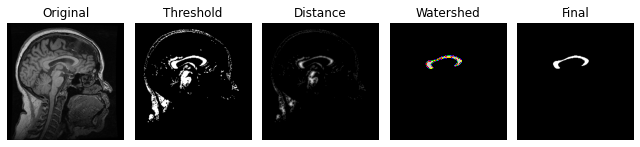

In [42]:
img, file_name = loadRandomImage()
print(file_name)

height, width = img.shape
threshold_sensitivity = 20

brainstem_x, brainstem_y = getBrainstemPosition(img)
brainstem = watershedFromPoint(img, brainstem_x, brainstem_y, threshold_sensitivity, 0,plot=True)

sub_img, min_x, min_y = getSubImgFromBrainstem(img, brainstem)

cc_x, cc_y = getCCPositionFromSubImg(sub_img, min_x, min_y)
cc = watershedFromPoint(img, cc_x, cc_y, threshold_sensitivity, 1,True)